In [10]:
# Import neccesary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing

### 1. Data loading

In [2]:
# Load dataset
df = pd.read_csv('review.csv')

# Print the structure and summary of the DataFrame
print("DataFrame Info:")
print(df.info())

# Display the first 5 rows of the data
print("\nFirst 5 rows:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463419 entries, 0 to 2463418
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   review_topic  object 
 2   review        object 
 3   score         float64
dtypes: float64(1), int64(1), object(2)
memory usage: 75.2+ MB
None

First 5 rows:
   Unnamed: 0  review_topic  \
0           0  ComputerGame   
1           1  ComputerGame   
2           2  ComputerGame   
3           3  ComputerGame   
4           4  ComputerGame   

                                              review  score  
0                            Best 👌 mobile game ever    5.0  
1  It's a really good game I'm going to rate it 1...    5.0  
2  Call of duty mobile is a very interesting game...    5.0  
3  I love the game in it's entirety, the only thi...    3.0  
4  Unplayable size.... its portable. Update 2024 ...    1.0  


### 2. Data Cleaning

In [3]:
# Display initial shape of the DataFrame
print("Initial shape:", df.shape)

# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Drop rows with missing values in review or score
df.dropna(subset=['review', 'score'], inplace=True)

# Define a cleaning function for the review text
def clean_text(text):
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply the cleaning function to the review column
df['review'] = df['review'].apply(clean_text)

# Display the shape of the DataFrame after cleaning
print("Shape after cleaning:", df.shape)

# Display the first few rows of the cleaned DataFrame
print(df.head())

Initial shape: (2463419, 4)
Shape after cleaning: (2438576, 4)
   Unnamed: 0  review_topic  \
0           0  ComputerGame   
1           1  ComputerGame   
2           2  ComputerGame   
3           3  ComputerGame   
4           4  ComputerGame   

                                              review  score  
0                             best  mobile game ever    5.0  
1  it's a really good game i'm going to rate it 1...    5.0  
2  call of duty mobile is a very interesting game...    5.0  
3  i love the game in it's entirety, the only thi...    3.0  
4  unplayable size.... its portable. update 2024 ...    1.0  


### 3. Feature engineering

In [4]:
# Create numeric labels from scores
def score_to_label(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['label'] = df['score'].apply(score_to_label)

# Create a DataFrame with only the text and label columns 
bert_df = df[['review', 'label']].rename(columns={'review': 'text'})
print("\nData sample for BERT:")
print(bert_df.head())

# Count the number of instances for each label
label_counts = bert_df['label'].value_counts()
print("Label counts:")
print(label_counts)



Data sample for BERT:
                                                text  label
0                             best  mobile game ever      2
1  it's a really good game i'm going to rate it 1...      2
2  call of duty mobile is a very interesting game...      2
3  i love the game in it's entirety, the only thi...      1
4  unplayable size.... its portable. update 2024 ...      0
Label counts:
label
2    2160005
0     159614
1     118957
Name: count, dtype: int64


##### As the positive class vastly outnumbers the other two, which can lead to the model being biased toward predicting label 2, classess are undersamplerd to balance the distribution. Label 2 will be reduced to the size of 200K

In [5]:
# Set the desired sample size for class 2
set_class2_size = 200000

# Undersample class 2 (Positive) to the desired count
df2 = bert_df[bert_df['label'] == 2].sample(n=set_class2_size, random_state=42)

# Keep class 0 (Negative) and class 1 (Neutral) as they are
df0 = bert_df[bert_df['label'] == 0]
df1 = bert_df[bert_df['label'] == 1]

# Combine the datasets and shuffle
balanced_df = pd.concat([df0, df1, df2]).sample(frac=1, random_state=42)
print("\nBalanced label counts:")
print(balanced_df['label'].value_counts())


Balanced label counts:
label
2    200000
0    159614
1    118957
Name: count, dtype: int64


# Model Building

### Baseline Model 1 using Logistic Regression and TF-IDF


Baseline Model: Logistic Regression + TF-IDF
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     31832
           1       0.64      0.54      0.59     23722
           2       0.82      0.88      0.85     40161

    accuracy                           0.77     95715
   macro avg       0.75      0.74      0.74     95715
weighted avg       0.76      0.77      0.76     95715



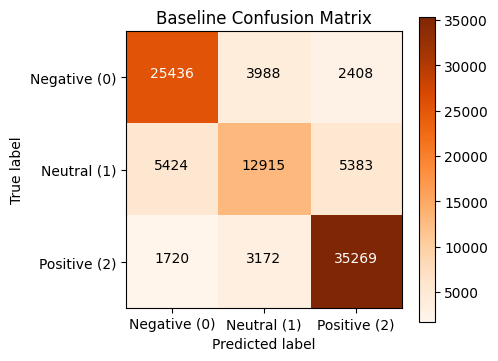

In [20]:
# Split the balanced data into training and testing sets for baseline
X_train, X_test, y_train, y_test = train_test_split(balanced_df['text'], balanced_df['label'],
                                                    test_size=0.2, random_state=42)

# Vectorize using TF-IDF
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict and Evaluate
y_pred = clf.predict(X_test_tfidf)
print("\nBaseline Model: Logistic Regression + TF-IDF")
print(classification_report(y_test, y_pred, digits=2))
cm_baseline = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm_baseline, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Baseline Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Negative (0)', 'Neutral (1)', 'Positive (2)'])
plt.yticks(tick_marks, ['Negative (0)', 'Neutral (1)', 'Positive (2)'])
thresh = cm_baseline.max() / 2.
for i in range(cm_baseline.shape[0]):
    for j in range(cm_baseline.shape[1]):
        plt.text(j, i, format(cm_baseline[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_baseline[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


### Baseline Model 2 using LSTM and Embedding Layers with early stopping

In [8]:
# Set hyperparameters
vocab_size = 20000      # Maximum number of words in the vocabulary
embedding_dim = 100     # Dimension of the embedding vector
max_length = 100        # Maximum length of each review in tokens
padding_type = 'post'   # Pad sequences at the end
trunc_type = 'post'     # Truncate sequences at the end if longer than max_length
oov_tok = "<OOV>"       # Token for out-of-vocabulary words
num_epochs = 5          
batch_size = 128       

# Prepare  text and label data 
texts = balanced_df['text'].tolist()     
labels = balanced_df['label'].tolist()    

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Initialize and fit the Tokenizer on the training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences so that all inputs have the same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Three classes: Negative, Neutral, Positive
])

# Compile the model with sparse categorical crossentropy
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_padded, 
    np.array(train_labels), 
    epochs=num_epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[early_stop]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_padded, np.array(test_labels), verbose=1)
print("Test Accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,125,699
Trainable params: 2,125,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2393/2393 [=========================

2992/2992 [==============================] - 13s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83     31832
           1       0.63      0.76      0.69     23722
           2       0.90      0.87      0.88     40161

    accuracy                           0.81     95715
   macro avg       0.80      0.80      0.80     95715
weighted avg       0.83      0.81      0.82     95715



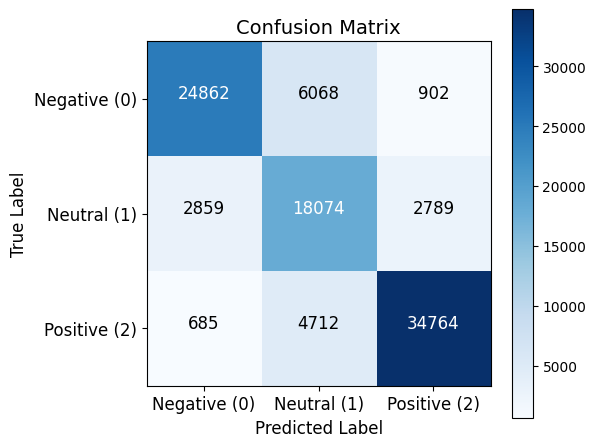

In [9]:
# Get predictions from the test dataset 
predictions = model.predict(test_padded)
preds = np.argmax(predictions, axis=1)
true_labels = np.array(test_labels)

# Print the classification report
report = classification_report(true_labels, preds, digits=2)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix 
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
classes = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## Advanced Model: Fine-tuning BERT for Sentiment Classification
### Version 1 non-stop BERT, training data = 100K

In [23]:
if __name__ == '__main__':
    # Split the data into training and testing sets
    train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
    
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    #Run with subset to decrease run time
    train_dataset = train_dataset.shuffle(seed=42).select(range(100000))
    test_dataset = test_dataset.shuffle(seed=42).select(range(10000))
    # Load the pre-trained BERT tokenizer and model
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Tokenize the datasets
    def tokenize_function(examples, tokenizer=tokenizer):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    # Use multiple CPU cores for tokenization 
    num_cores = 8  
    train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=num_cores)
    test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=num_cores)

    # Set the format for PyTorch to use the necessary columns
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results",
        eval_strategy="epoch",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_logs",
        logging_steps=10,
        report_to=[]
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Train the model
    trainer.train()

    # Evaluate the model's performance on the test set
    results = trainer.evaluate()
    print("\nEvaluation Results:")
    print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.370400,0.442898
2,0.359900,0.465202
3,0.272000,0.484072
4,0.249500,0.645525
5,0.118100,0.772141



Evaluation Results:
{'eval_loss': 0.7721409201622009, 'eval_runtime': 81.2505, 'eval_samples_per_second': 123.076, 'eval_steps_per_second': 7.692, 'epoch': 5.0}



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3332
           1       0.72      0.76      0.74      2502
           2       0.92      0.91      0.91      4166

    accuracy                           0.85     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.85      0.85     10000



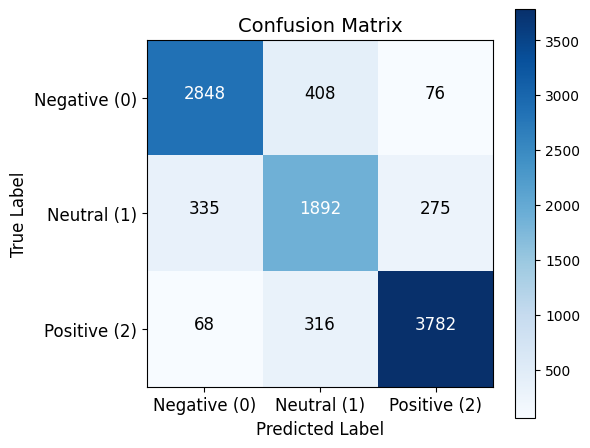

In [24]:
# Get predictions from the model on the test dataset
predictions_output = trainer.predict(test_dataset)
# Convert logits to predicted labels
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Print classification report
report = classification_report(true_labels, preds, digits=2)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix using matplotlib
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
classes = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

Epoch 1-3: The training loss decreases gradually (from 0.37 to 0.27), and the validation loss increases slowly (from 0.44 to 0.48).
Epoch 4-5: The training loss drops significantly (down to 0.25 then 0.12), but the validation loss jumps to 0.65 and then 0.77.
This divergence between training and validation loss suggests the model is overfitting. The model will be revert manually back to around epoch 3 to balance training and validation lossess. 

In [33]:
checkpoint_path = r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results\checkpoint-18000"
model = BertForSequenceClassification.from_pretrained(checkpoint_path)
model.to("cuda")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  

trainer.model = model
results = trainer.evaluate()
print(results)


{'eval_loss': 0.4953516721725464}



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3332
           1       0.73      0.70      0.72      2502
           2       0.91      0.91      0.91      4166

    accuracy                           0.85     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.85      0.85      0.85     10000



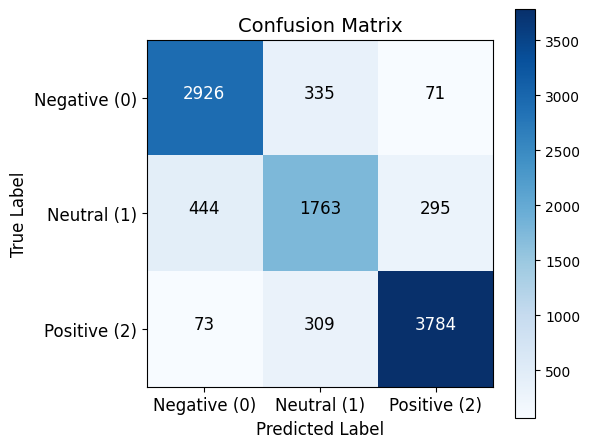

In [34]:
# Get predictions from the model on the test dataset
predictions_output = trainer.predict(test_dataset)
# Convert logits to predicted labels
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Print classification report
report = classification_report(true_labels, preds, digits=2)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix using matplotlib
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
classes = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### Version 2 Auto-stop BERT+best saving, training data = 100K

In [6]:
if __name__ == '__main__':
    # Split the data into training and testing sets
    train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
    
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Run with subset to decrease run time
    train_dataset = train_dataset.shuffle(seed=42).select(range(100000))
    test_dataset = test_dataset.shuffle(seed=42).select(range(10000))
    
    # Load the pre-trained BERT tokenizer and model
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Tokenize the datasets
    def tokenize_function(examples, tokenizer=tokenizer):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    # Use multiple CPU cores for tokenization 
    num_cores = 8  
    train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=num_cores)
    test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=num_cores)

    # Set the format for PyTorch to use the necessary columns
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    # Define training arguments, enabling best model saving and early stopping
    training_args = TrainingArguments(
        output_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2",
        eval_strategy="epoch",
        save_strategy="epoch",               
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_logs",
        logging_steps=10,
        report_to=[],
        load_best_model_at_end=True,       
        metric_for_best_model="eval_loss"  
    )

    # Initialize the Trainer with an early stopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model 
    trainer.train()

    # Evaluate the model's performance on the test set
    results = trainer.evaluate()
    print("\nEvaluation Results:")
    print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

C:\Users\zapor\anaconda3\envs\tf_gpu\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,0.373700,0.436634
2,0.294600,0.422781
3,0.310900,0.534669



Evaluation Results:
{'eval_loss': 0.4227809011936188, 'eval_runtime': 83.3025, 'eval_samples_per_second': 120.044, 'eval_steps_per_second': 7.503, 'epoch': 3.0}


### Reload best model (for use for reloading model after restart of console)

In [8]:
#find best model out of checkpoints (should be epoch 2 at checkpoint-12500 based on above result)
checkpoints = [
    r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-6250",
    r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-12500",
    r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-18750"
]

for ckpt_path in checkpoints:
    trainer_state_path = os.path.join(ckpt_path, "trainer_state.json")
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    best_ckpt = trainer_state.get("best_model_checkpoint", None)
    print(f"{ckpt_path} => best_model_checkpoint: {best_ckpt}")


C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-6250 => best_model_checkpoint: C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-6250
C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-12500 => best_model_checkpoint: C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-12500
C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-18750 => best_model_checkpoint: C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-12500


Best model is indeed after checkpoint 12500

In [19]:
# Split balanced DataFrame to obtain the test set 
_, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

test_dataset = Dataset.from_pandas(test_df)

# Select a subset for faster evaluation
test_dataset = test_dataset.shuffle(seed=42).select(range(10000))

# Load the pre-trained tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define the tokenization function and include a tokenizer parameter
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize the test dataset using multiple CPU cores; pass the tokenizer via fn_kwargs
num_cores = 8
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=num_cores, fn_kwargs={'tokenizer': tokenizer})
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define the training arguments 
training_args = TrainingArguments(
    output_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2",
    eval_strategy="epoch",
    save_strategy="epoch",               
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir=r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_logs",
    logging_steps=10,
    report_to=[],
    load_best_model_at_end=True,       
    metric_for_best_model="eval_loss"
)

# Define the best checkpoint path from previous training
best_checkpoint = r"C:\Users\zapor\OneDrive\桌面\IE 7500\Project\bert_results_2\checkpoint-12500"

# Reload the trained model from the best checkpoint and move it to GPU 
model = BertForSequenceClassification.from_pretrained(best_checkpoint)
model.to("cuda")  

# Initialize the Trainer with the reloaded model and the test dataset
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]


Evaluation Results:
{'eval_loss': 0.4227809011936188, 'eval_model_preparation_time': 0.003, 'eval_runtime': 81.1085, 'eval_samples_per_second': 123.292, 'eval_steps_per_second': 7.706}



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3332
           1       0.72      0.73      0.73      2502
           2       0.92      0.90      0.91      4166

    accuracy                           0.85     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.85      0.85      0.85     10000



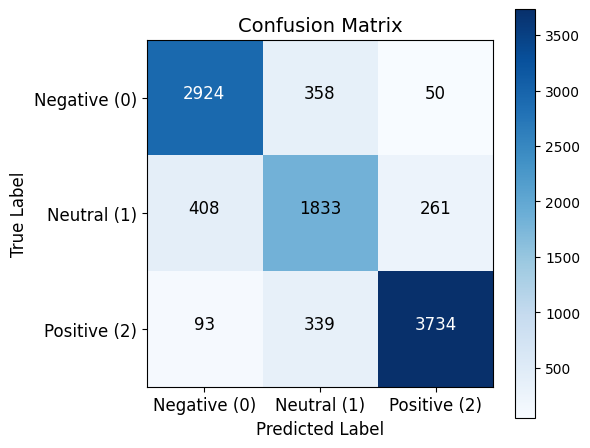

In [20]:
# Get predictions from the test dataset
predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Print the classification report
report = classification_report(true_labels, preds, digits=2)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix using matplotlib
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
classes = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()